# Add your own Objects and Styles to Image Generation Models

This notebook provides a practical framework for fine-tuning existing image generation models, such as Stable Diffusion XL, using [DreamBooth](https://huggingface.co/docs/diffusers/training/dreambooth) and Azure Machine Learning. The primary goal is to enable the model to generate images of specific subjects or concepts, based on a set of sample images. This process can be used to insert a specific object into entirely new contexts or scenes.

Potential business applications facilitated by this framework include content creation, product visualization, advertising and marketing, as well as education and training. The fine-tuning operation will be executed using Azure Machine Learning, leveraging its scalability for training on powerful GPU compute resources and its capabilities for managing and tracking experiments and image datasets.

In this solution framework, you will:

1. Connect to your Azure Machine Learning Workspace and establish the required resources.
2. Provide training images of the specific subject to be incorporated into the image generation model.
3. Configure and initiate the fine-tuning training job.
4. Review the experiment results and retrieve key artifacts, including model checkpoints.
5. Generate new images of your chosen subject in diverse scenes.

This notebook is designed as a solution template for leveraging Azure ML and DreamBooth for fine-tuning image generation models within business contexts, providing a solution framework that can be adapted to specific needs and applications.

__Development resources__:
- Dreambooth scripts: https://github.com/huggingface/diffusers/tree/main/examples
- Fine-Tuning Reference: https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/README_sdxl.md


The fine-tuning process will implement the following workflow:

<img src="../media/process.png" alt="drawing" style="width:800px;"/>

# Setup

In [ ]:
# uncomment if you need to install the required packages in the active environment of your notebook
%pip install --upgrade -r ../requirements.txt


### https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/README_sdxl.md

In [1]:
import sys
sys.path.insert(0, '..')
import os
import shutil
import random
from azure.ai.ml import automl, Input, Output, MLClient, command, load_job
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

from azure.ai.ml.entities import Data, Environment, AmlCompute
from azure.ai.ml.constants import AssetTypes
from azure.core.exceptions import ResourceNotFoundError

import matplotlib.pyplot as plt

import mlflow
from mlflow.tracking.client import MlflowClient

from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch
from utils import show_images

### https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/README_sdxl.md

In [ ]:
# Download the Dog dataset from HG only for the first time
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

In [2]:
# Set central variables
subscription_id =  "2a7eed04-714e-4ba9-96ba-47355c32a8d6"
resource_group = "AML-RG" # adjust if you have chosen a different name 
workspace_name = "aml-rs" # adjust if you have chosen a different name

local_train_data = './train-data/dog/' # Azure ML dataset will be created for training on this content
generated_images = './results/dog'

azureml_dataset_name = 'dog' # Name of the dataset 
# train_target = 'gpu-cluster'
train_target = 'gpu-cluster-96'
experiment_name = 'dreambooth-finetuning'

# Show Training Samples
We provide sample images that you can use as a starting point. When training with your own subjects, we recommend supplying at least 10 high-quality images. Each image should ideally have a resolution of 1024x1024 pixels, but any similar resolution can work as well. To quickly resize your images to the necessary format, you can use the [Bulk Image Resizing Made Easy (BIRME)](https://www.birme.net/?image_format=jpeg&quality_jpeg=100&rename=hairwax-&rename_start=42) tool, which is readily available online.

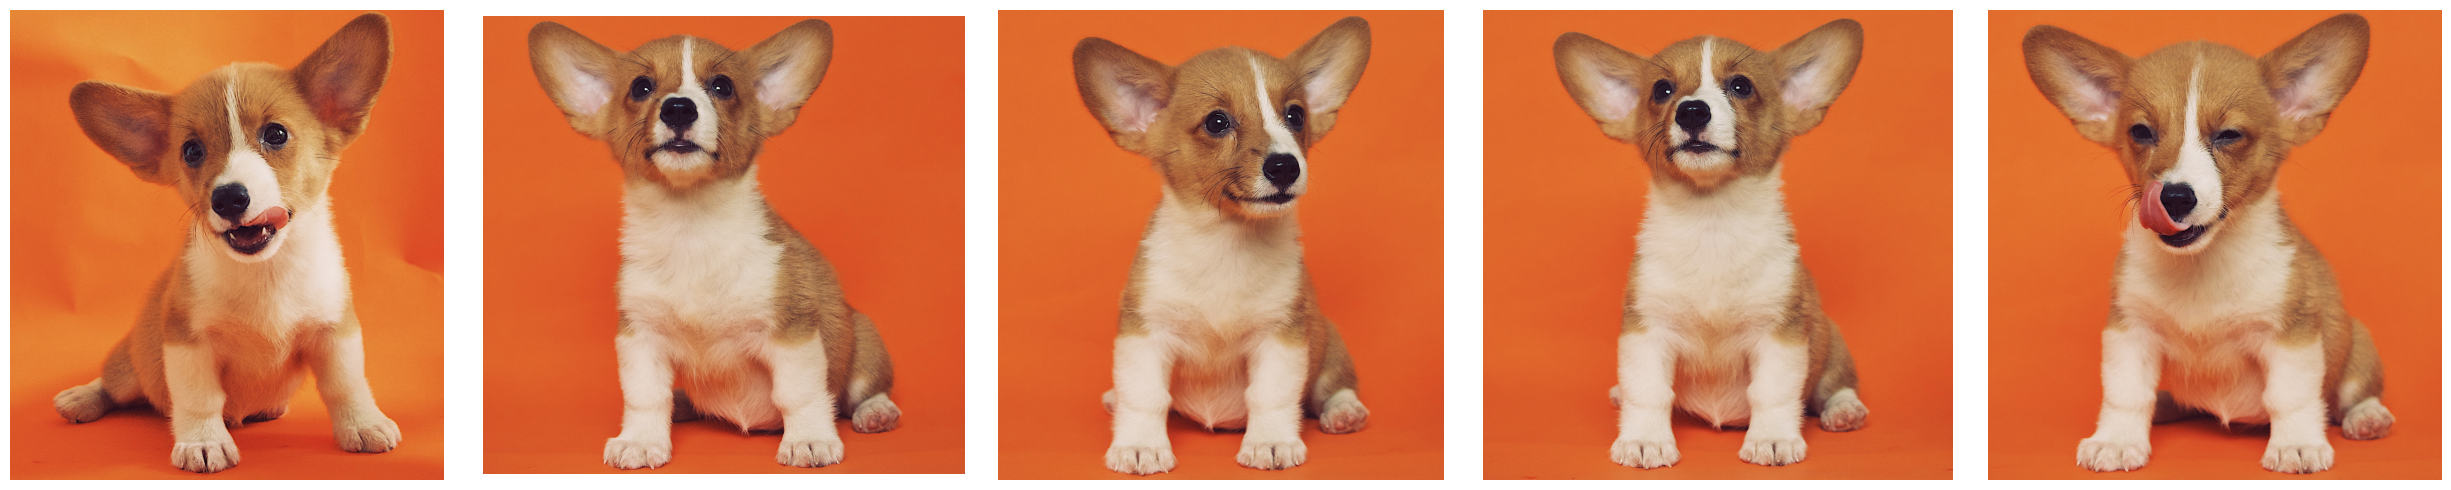

In [3]:
image_list = [os.path.join(local_train_data, image) for image in os.listdir(local_train_data) if image.endswith('.png') or image.endswith('.jpeg') or image.endswith('.jpg')]

show_images(images=image_list[:10], cols=5, source='local')


## Connect to Azure Machine Learning Workspace

In [ ]:
# Set credential
try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

# Get handle to Workspace 
try:
    ml_client = MLClient.from_config(credential=credential)
except Exception as ex:

    ml_client = MLClient(subscription_id=subscription_id, 
                         resource_group_name= resource_group,
                         workspace_name= workspace_name,
                         credential= credential)
    
print ('Test Workspace access by listing compute resources ... ')
print([compute.name for compute in ml_client.compute.list()])

## Establish required Azure ML Resources

The subsequent steps will lead to the creation of the following resources:

1. A GPU cluster for the fine-tuning job.
2. An Azure ML Dataset registration for the training images.
3. A Python environment registration for executing the fine-tuning job.  

__Note__: These steps only need to be performed once. If you've already executed this cell, you may proceed directly to the [Show Training Samples](#Show-Training-Samples) section. If updates to these resources are necessary, feel free to re-run these cells.

In this demonstration, we utilize low-priority compute for cost efficiency. While low-priority VMs offer significant cost savings compared to standard dedicated compute, availability may fluctuate, and there is a risk of training jobs being pre-empted.


In [5]:
try:
    _ = ml_client.compute.get(train_target)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=train_target,
        type="amlcompute",
        size="Standard_NC96ads_A100_v4", # 4 x A100, 80 GB GPU memory each
        tier="low_priority",
        idle_time_before_scale_down=600,
        min_instances=0,
        max_instances=2,
    )
    ml_client.begin_create_or_update(compute_config)

Found existing compute target.


In [ ]:
# Register dataset
my_data = Data(
    path= local_train_data,
    type= AssetTypes.URI_FOLDER,
    description= "Training images for Dreambooth finetuning",
    name= azureml_dataset_name
)
ml_client.data.create_or_update(my_data)

In [ ]:
environment = Environment(
    image="mcr.microsoft.com/azureml/aifx/stable-ubuntu2004-cu115-py38-torch1110:biweekly.202302.1",
    conda_file="./dreambooth-conda-sdxl.yaml",
    name="dreambooth-env",
    description="Dreambooth training environment",
) 

ml_client.environments.create_or_update(environment)

# Configure and Submit Fine-Tuning Job

We have validated the solution through multiple fine-tuning runs, employing the `stabilityai/stable-diffusion-xl-base-1.0` and `madebyollin/sdxl-vae-fp16-fix` models. The quality of the resulting model can be significantly influenced by various hyperparameters, including training steps, prompts, learning rate, and so on.

For guidance on configuring Dreambooth experiments to achieve optimal results, we recommend reviewing this [blogpost](https://huggingface.co/blog/dreambooth).

The reference for the fine-tuning can be found here: [reference](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/README_sdxl.md)

__Note for fine-tuning your own subjects:__  
The job will also create final test images after training by running the [`src/inference_sdxl.py`](src/inference_sdxl.py) script. The file contains prompts for our dog example use case. Review and adjust the prompts, suffix and negative prompts in [`src/inference_sdxl.py`](src/inference_sdxl.py) for fine-tuning your own subjects __before running the next cell__.


## Fine-Tuning Prompts

To fine-tune SDXL with Dreambooth, two prompts are needed ([reference](https://jina.ai/news/how-to-personalize-stable-diffusion-for-all-the-things/)):
1. a RARE_IDENTIFIER: a token the model is unfamiliar with, a unique reference to the object you want Stable Diffusion to learn, e.g sks or btb
1. a CATEGORY: The prompt for the prior preservation loss is the category of the style or object in question, like dog or painting.

Example Setup: 
1. Take 5-8 high quality images of an object (e.g. your dog)
1. your object images + prompt e.g. "a sks dog" 
1. Various object images + prompt e.g. "a dog" (optional, but yields better results)


In [ ]:
# Retrieve latest version of dataset
latest_version = [dataset.latest_version for dataset in ml_client.data.list() if dataset.name == azureml_dataset_name][0]
dataset_asset = ml_client.data.get(name= azureml_dataset_name, version= latest_version)
print(f'Latest version of {azureml_dataset_name}: {latest_version}')

inputs = {"input_data": Input(type=AssetTypes.URI_FOLDER, path=f'azureml:{azureml_dataset_name}:{latest_version}'),}
outputs = {"output_dir": Output(type=AssetTypes.URI_FOLDER)}

job = command(
    inputs = inputs,
    outputs = outputs,
    code = "./src",
    command = '''python prepare.py && accelerate launch --num_processes 1 train_dreambooth_lora_sdxl.py \
                --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
                --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
                --instance_data_dir=${{inputs.input_data}} \
                --instance_prompt="photo of a sks dog" \
                --validation_prompt="photo of a sks dog" \
                --class_data_dir=${{inputs.class_data}} \
                --class_prompt="photo of a dog" \
                --resolution=1024 \
                --lr_scheduler="constant" \
                --output_dir="outputs/models" \
                --train_batch_size=1 \
                --mixed_precision="fp16" \
                --gradient_accumulation_steps=4 \
                --lr_warmup_steps=0 \
                --max_train_steps=15000 \
                --learning_rate=1e-5 \
                --validation_epochs=50 \
                --seed="0" && python inference_sdxl.py --model_path outputs/models''',
    environment = "dreambooth-env@latest",
    compute = train_target, 
    experiment_name = experiment_name,
    display_name= "Dreambooth Dog example",
    )

returned_job = ml_client.jobs.create_or_update(job)
returned_job

Proceed to the Job within Azure ML Studio to further track the progression of your fine-tuning operation. Here, you can opt for the __Images__ section, which presents you with visuals captured during various validation steps:

<img src="../media/validation-sample.png" alt="drawing" style="width:800px;"/>

These validation images are valuable indicators of how well the model is adapting to your specific subject. As the validation steps proceed, you should see your subject being more accurately represented in the images. However, it's important to maintain a balance. Prolonged fine-tuning runs can potentially lead to overfitting, which in turn may manifest as noticeable visual artifacts in the images.

Moreover, an overfitted model could show a tendency to just replicate the instance images, reducing its flexibility to generalize your inference prompts. For instance, the model may struggle when tasked with incorporating your subject into novel scenes. 

# Download Model

The SDXL model consists of two stages: the base model and the refiner model. The base model is a text-to-image model, and the refiner model is an image-to-image model. [Image Source.](https://medium.com/@lauracarnevali/simplify-image-creation-with-the-sdxl-refiner-on-a1111-6341e606398b)

<img src="../media/sdxl_stages.png" alt="drawing" style="width:800px;"/>

In [ ]:
# job_name = returned_job.name # use above job
job_name = "frosty_sprout_5bkf9rpjqs" # pick previous job from history

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(name=ml_client.workspace_name).mlflow_tracking_uri

# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# Initialize MLFlow client
mlflow_client = MlflowClient()

mlflow_run = mlflow_client.get_run(job_name)

mlflow.artifacts.download_artifacts(run_id= mlflow_run.info.run_id, 
                                    artifact_path="outputs/models/", # Azure ML job output
                                    dst_path="./train-artifacts") # local folder

In [10]:
# Workaround: pytorch_lora_weights.bin is erroneously downloaded as a folder with the model files instead as a file. Manually checking file type and downloading individually if this is the case

json_path = "./train-artifacts/outputs/models/pytorch_lora_weights.bin"

if os.path.isdir("./train-artifacts/outputs/models/pytorch_lora_weights.bin"):
    shutil.rmtree(json_path)
    mlflow.artifacts.download_artifacts(run_id= mlflow_run.info.run_id, 
                                    artifact_path="outputs/models/pytorch_lora_weights.bin", # Azure ML job output
                                    dst_path="./train-artifacts") # local folder

In [6]:
from diffusers import DiffusionPipeline, StableDiffusionXLImg2ImgPipeline

## Create the base model pipeline and the refiner pipeline

pipe = DiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-xl-base-1.0', torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.load_lora_weights(torch.load(f'./train-artifacts/outputs/models/pytorch_lora_weights.bin'))

# Load the refiner.
refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16"
)
refiner.to("cuda")


# TODO: enable reuse specific checkpoint: https://huggingface.co/docs/diffusers/training/dreambooth#inference-from-a-saved-checkpoint

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.20.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-refiner-1.0",
  "force_zeros_for_empty_prompt": false,
  "requires_aesthetics_score": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    null,
    null
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# Generate Images

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

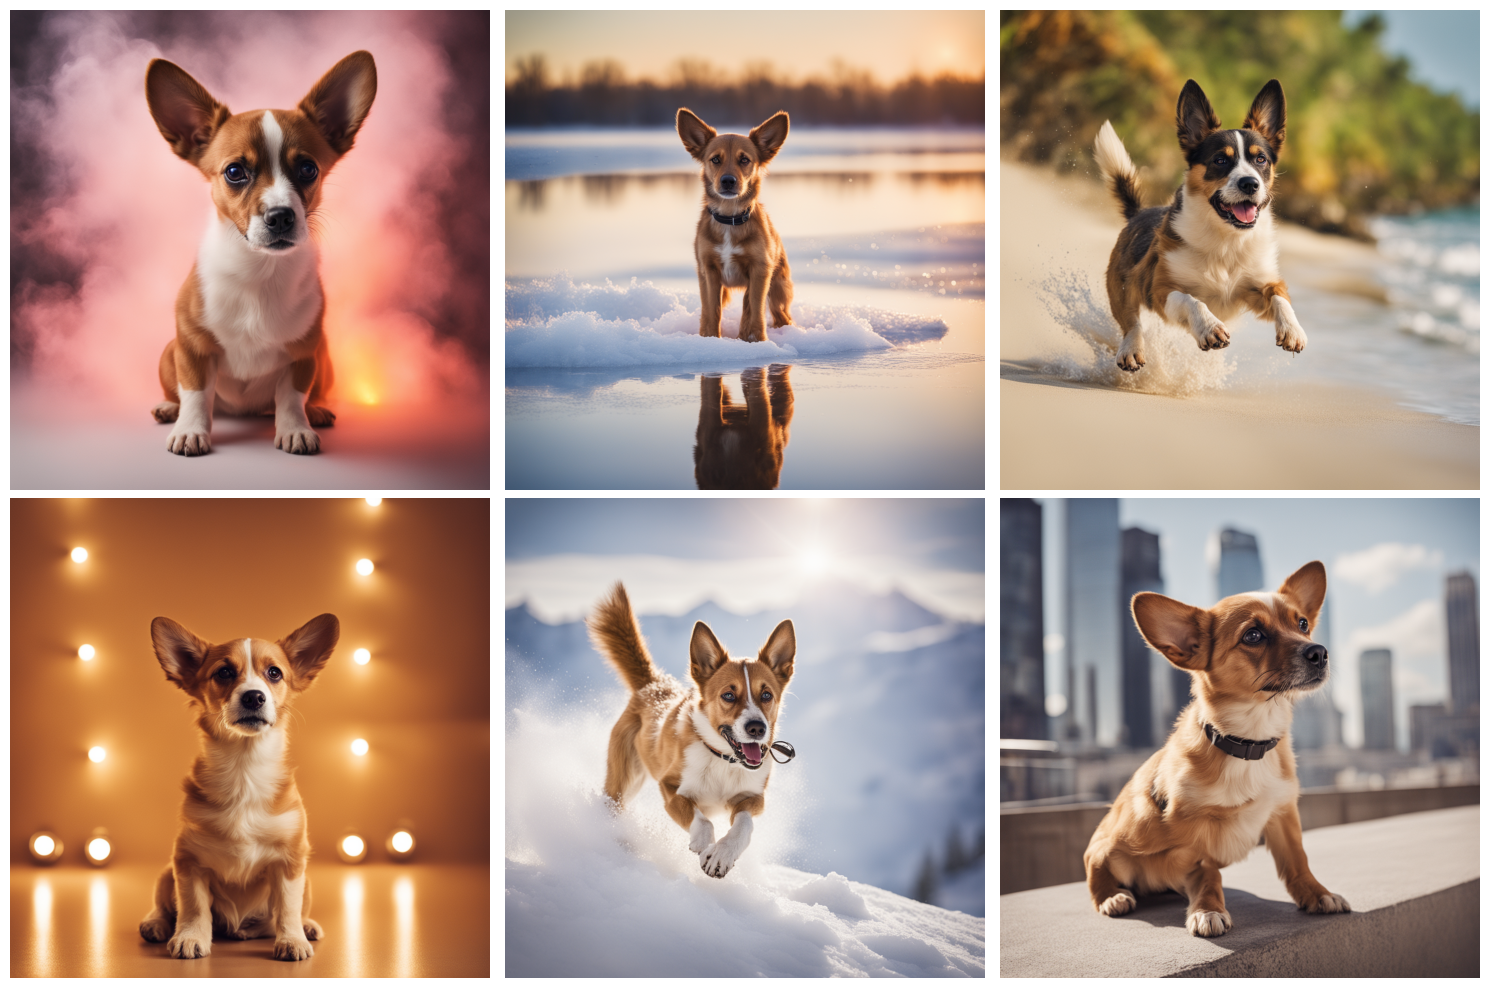

In [7]:
def generate_images(prompt, num_images=1):

    suffix = ", (high detailed skin:1.2), 8k uhd, dslr, advertising photography, high quality, film grain, real-world, unedited, photorealistic, Fujifilm XT3, natural"    
    negative_prompt = '(semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck'

    rand_num = random.randint(100000, 999999)
    generator = torch.Generator("cuda").manual_seed(rand_num)

    image = pipe(prompt=prompt, negative_prompt=negative_prompt,output_type="latent", generator=generator).images[0]
    image = refiner(prompt=prompt, image=image[None, :], generator=generator).images[0]

    return image


prompts = [
"product studio photography of a sks dog racing over snow in an alpine mountain",
"product studio photography of a sks dog racing over beach in a tropical island",
"product studio photography of a sks dog in a glamorous showroom with lots of spotlights and lighting",
"product studio photography of a sks dog in a ultra-modern urban setting, in some futuristic city",
"A magical sks dog, futuristic, stunning product studio photography, low-key lighting, bokeh, smoke effects",
"product studio photography of a sks dog on icy lake with reflections. bokeh, blue sky.",
]



if not os.path.exists(generated_images):
    os.makedirs(generated_images)
else:
    shutil.rmtree(generated_images)
    os.makedirs(generated_images)


for prompt in prompts:
        image = generate_images(prompt)

        rand_num = random.randint(100000, 999999)
        image.save(os.path.join(generated_images, f"image-{rand_num}.png"))


image_list = [os.path.join(generated_images, image) for image in os.listdir(generated_images) if image.endswith('.png')]

show_images(images=image_list, cols=3, source='local')
